**PHASE 4: ANALYSIS - Research Question 3**

Purpose: Evaluate alignment between clustering and ArXiv categorization  
Input: cluster_profiles_300d.pkl, cluster_profiles_500d.pkl, metadata  
Output: Category alignment metrics, confusion analysis, purity assessment  
Algorithm: Confusion matrix, purity calculation, alignment scoring  
ML Involved: ✗ NO - Pure analysis of clustering results  
Runtime: ~10-15 minutes  

Research Question 3:
"How well does content-based clustering align with ArXiv's human-curated categorization system?"

Approach:
- Calculate cluster-category confusion matrices
- Measure category purity and cluster dominance
- Identify well-aligned vs misaligned clusters
- Test whether categories predict cluster membership
- Compare both paths' alignment quality

In [8]:
# imports

import pandas as pd
import numpy as np
import os
import sys
import joblib
from collections import Counter
from datetime import datetime
from scipy.stats import entropy
from sklearn.metrics import jaccard_score, normalized_mutual_info_score, adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns

# add project root

sys.path.append('..')
from config import RANDOM_STATE

In [2]:
# load cluster profiles from both paths

print("Loading cluster profiles...")
profiles_300d = joblib.load('data/processed/cluster_profiles_300d.pkl')
profiles_500d = joblib.load('data/processed/cluster_profiles_500d.pkl')
print(f"✓ 300d: {profiles_300d['n_clusters']} clusters")
print(f"✓ 500d: {profiles_500d['n_clusters']} clusters")

# load cluster labels

labels_300d = pd.read_pickle('data/processed/cluster_labels_300d.pkl')
labels_500d = pd.read_pickle('data/processed/cluster_labels_500d.pkl')
print(f"✓ Cluster labels loaded")

# load metadata

df_metadata = pd.read_pickle('data/processed/arxiv_text_cleaned.pkl')
print(f"✓ Metadata: {len(df_metadata):,} papers")

# merge with cluster assignments

df_300d = df_metadata.merge(labels_300d, on='id', how='left')
df_500d = df_metadata.merge(labels_500d, on='id', how='left')
print(f"✓ Merged dataframes created")

print("DATA LOADED - READY FOR ANALYSIS")

Loading cluster profiles...
✓ 300d: 50 clusters
✓ 500d: 50 clusters
✓ Cluster labels loaded
✓ Metadata: 2,384,622 papers
✓ Merged dataframes created
DATA LOADED - READY FOR ANALYSIS


In [9]:
# RESEARCH QUESTION 3: Category alignment

print("RESEARCH QUESTION 3: CATEGORY ALIGNMENT")
print("Question: How well does content-based clustering align with")
print("          ArXiv's human-curated categorization system?\n")

print("Calculating alignment metrics for both paths...\n")

def calculate_alignment_metrics(df_with_clusters, n_clusters):
    """
    Calculate how well clusters align with ArXiv categories
    
    Metrics:
    1. Category purity per cluster (already have)
    2. Cluster dominance per category
    3. Normalized Mutual Information (overall alignment)
    4. Adjusted Rand Index
    5. V-measure (harmonic mean of homogeneity and completeness)
    """
    from sklearn.metrics import v_measure_score, homogeneity_score, completeness_score
    
    cluster_labels = df_with_clusters['cluster_id'].values
    category_labels = df_with_clusters['primary_category'].values
    
    # overall alignment metrics
    nmi = normalized_mutual_info_score(category_labels, cluster_labels)
    ari = adjusted_rand_score(category_labels, cluster_labels)
    v_measure = v_measure_score(category_labels, cluster_labels)
    homogeneity = homogeneity_score(category_labels, cluster_labels)
    completeness = completeness_score(category_labels, cluster_labels)
    
    # per-cluster metrics
    cluster_metrics = {}
    for cid in range(n_clusters):
        cluster_papers = df_with_clusters[df_with_clusters['cluster_id'] == cid]
        
        if len(cluster_papers) == 0:
            continue
        
        # category distribution
        cat_dist = cluster_papers['primary_category'].value_counts()
        
        # purity (fraction in dominant category)
        purity = cat_dist.iloc[0] / len(cluster_papers) if len(cat_dist) > 0 else 0
        
        # entropy (category diversity)
        cat_probs = cat_dist / len(cluster_papers)
        cat_entropy = entropy(cat_probs)
        
        # dominant category info
        dominant_cat = cat_dist.index[0] if len(cat_dist) > 0 else None
        dominant_count = cat_dist.iloc[0] if len(cat_dist) > 0 else 0
        
        # number of categories
        n_categories = len(cat_dist)
        
        cluster_metrics[cid] = {
            'purity': purity,
            'entropy': cat_entropy,
            'dominant_category': dominant_cat,
            'dominant_count': dominant_count,
            'n_categories': n_categories,
            'size': len(cluster_papers)
        }
    
    # per-category metrics (how well does category map to clusters?)
    category_metrics = {}
    unique_categories = df_with_clusters['primary_category'].unique()
    
    for cat in unique_categories:
        cat_papers = df_with_clusters[df_with_clusters['primary_category'] == cat]
        
        if len(cat_papers) == 0:
            continue
        
        # cluster distribution for this category
        cluster_dist = cat_papers['cluster_id'].value_counts()
        
        # dominance (fraction in dominant cluster)
        dominance = cluster_dist.iloc[0] / len(cat_papers) if len(cluster_dist) > 0 else 0
        
        # entropy (cluster spread)
        cluster_probs = cluster_dist / len(cat_papers)
        cluster_entropy = entropy(cluster_probs)
        
        # dominant cluster
        dominant_cluster = cluster_dist.index[0] if len(cluster_dist) > 0 else None
        dominant_count = cluster_dist.iloc[0] if len(cluster_dist) > 0 else 0
        
        # number of clusters this category spans
        n_clusters_spanned = len(cluster_dist)
        
        category_metrics[cat] = {
            'dominance': dominance,
            'entropy': cluster_entropy,
            'dominant_cluster': dominant_cluster,
            'dominant_count': dominant_count,
            'n_clusters': n_clusters_spanned,
            'size': len(cat_papers)
        }
    
    return {
        'overall': {
            'nmi': nmi,
            'ari': ari,
            'v_measure': v_measure,
            'homogeneity': homogeneity,
            'completeness': completeness
        },
        'cluster_metrics': cluster_metrics,
        'category_metrics': category_metrics
    }

# calculate for 300d
print("Analyzing 300d alignment...")
alignment_300d = calculate_alignment_metrics(df_300d, profiles_300d['n_clusters'])
print(f"✓ 300d alignment calculated")

# calculate for 500d
print("Analyzing 500d alignment...")
alignment_500d = calculate_alignment_metrics(df_500d, profiles_500d['n_clusters'])
print(f"✓ 500d alignment calculated")


print("OVERALL ALIGNMENT METRICS")
print(f"\n{'Metric':<25} {'SVD-300d':<15} {'SVD-500d':<15} {'Interpretation'}")

for metric in ['nmi', 'ari', 'v_measure', 'homogeneity', 'completeness']:
    val_300 = alignment_300d['overall'][metric]
    val_500 = alignment_500d['overall'][metric]
    
    if metric == 'nmi':
        interp = "Information shared"
    elif metric == 'ari':
        interp = "Agreement (chance-adjusted)"
    elif metric == 'v_measure':
        interp = "Harmonic mean (H+C)"
    elif metric == 'homogeneity':
        interp = "Cluster purity"
    else:
        interp = "Category coverage"
    
    print(f"{metric.upper():<25} {val_300:<15.3f} {val_500:<15.3f} {interp}")

print("\nNote: All metrics 0-1 scale, higher = better alignment")

RESEARCH QUESTION 3: CATEGORY ALIGNMENT
Question: How well does content-based clustering align with
          ArXiv's human-curated categorization system?

Calculating alignment metrics for both paths...

Analyzing 300d alignment...
✓ 300d alignment calculated
Analyzing 500d alignment...
✓ 500d alignment calculated
OVERALL ALIGNMENT METRICS

Metric                    SVD-300d        SVD-500d        Interpretation
NMI                       0.321           0.324           Information shared
ARI                       0.079           0.090           Agreement (chance-adjusted)
V_MEASURE                 0.321           0.324           Harmonic mean (H+C)
HOMOGENEITY               0.284           0.286           Cluster purity
COMPLETENESS              0.368           0.374           Category coverage

Note: All metrics 0-1 scale, higher = better alignment


In [10]:
# Find best and worst aligned clusters
print("CLUSTER-CATEGORY ALIGNMENT ANALYSIS")

# 300d - Best aligned (high purity)
cluster_purities_300d = [(cid, data['purity']) 
                         for cid, data in alignment_300d['cluster_metrics'].items()]
best_aligned_300d = sorted(cluster_purities_300d, key=lambda x: x[1], reverse=True)[:10]

print("SVD-300d - Top 10 Best Aligned Clusters (High Category Purity):")
print()

for rank, (cid, purity) in enumerate(best_aligned_300d, 1):
    metrics = alignment_300d['cluster_metrics'][cid]
    top_terms = [t[0] for t in profiles_300d['top_terms'][cid][:10]]
    
    print(f"{rank}. Cluster {cid} - Purity: {purity:.3f}")
    print(f"   Size: {metrics['size']:,} papers")
    print(f"   Dominant category: {metrics['dominant_category']} ({metrics['dominant_count']:,} papers, {metrics['dominant_count']/metrics['size']*100:.1f}%)")
    print(f"   Category entropy: {metrics['entropy']:.3f}")
    print(f"   Spans {metrics['n_categories']} categories")
    print(f"   Top terms: {', '.join(top_terms[:8])}")
    print()

# 300d - Worst aligned (low purity, high entropy)
worst_aligned_300d = sorted(cluster_purities_300d, key=lambda x: x[1])[:10]

print("\n" + "-"*80)
print("SVD-300d - Top 10 Most Dispersed Clusters (Low Category Purity):")
print()

for rank, (cid, purity) in enumerate(worst_aligned_300d, 1):
    metrics = alignment_300d['cluster_metrics'][cid]
    top_terms = [t[0] for t in profiles_300d['top_terms'][cid][:10]]
    top_cats = list(profiles_300d['top_categories'][cid]['primary_categories'].items())[:5]
    
    print(f"{rank}. Cluster {cid} - Purity: {purity:.3f}")
    print(f"   Size: {metrics['size']:,} papers")
    print(f"   Spans {metrics['n_categories']} categories")
    print(f"   Category entropy: {metrics['entropy']:.3f}")
    print(f"   Top categories: {', '.join(f'{cat}({cnt})' for cat, cnt in top_cats[:3])}")
    print(f"   Top terms: {', '.join(top_terms[:8])}")
    print()

# 500d - Best aligned
cluster_purities_500d = [(cid, data['purity']) 
                         for cid, data in alignment_500d['cluster_metrics'].items()]
best_aligned_500d = sorted(cluster_purities_500d, key=lambda x: x[1], reverse=True)[:10]

print("\n" + "="*80)
print("SVD-500d - Top 10 Best Aligned Clusters (High Category Purity):")
print()

for rank, (cid, purity) in enumerate(best_aligned_500d, 1):
    metrics = alignment_500d['cluster_metrics'][cid]
    top_terms = [t[0] for t in profiles_500d['top_terms'][cid][:10]]
    
    print(f"{rank}. Cluster {cid} - Purity: {purity:.3f}")
    print(f"   Size: {metrics['size']:,} papers")
    print(f"   Dominant category: {metrics['dominant_category']} ({metrics['dominant_count']:,} papers, {metrics['dominant_count']/metrics['size']*100:.1f}%)")
    print(f"   Category entropy: {metrics['entropy']:.3f}")
    print(f"   Spans {metrics['n_categories']} categories")
    print(f"   Top terms: {', '.join(top_terms[:8])}")
    print()

# 500d - Worst aligned
worst_aligned_500d = sorted(cluster_purities_500d, key=lambda x: x[1])[:10]

print("\n" + "-"*80)
print("SVD-500d - Top 10 Most Dispersed Clusters (Low Category Purity):")
print()

for rank, (cid, purity) in enumerate(worst_aligned_500d, 1):
    metrics = alignment_500d['cluster_metrics'][cid]
    top_terms = [t[0] for t in profiles_500d['top_terms'][cid][:10]]
    top_cats = list(profiles_500d['top_categories'][cid]['primary_categories'].items())[:5]
    
    print(f"{rank}. Cluster {cid} - Purity: {purity:.3f}")
    print(f"   Size: {metrics['size']:,} papers")
    print(f"   Spans {metrics['n_categories']} categories")
    print(f"   Category entropy: {metrics['entropy']:.3f}")
    print(f"   Top categories: {', '.join(f'{cat}({cnt})' for cat, cnt in top_cats[:3])}")
    print(f"   Top terms: {', '.join(top_terms[:8])}")
    print()

CLUSTER-CATEGORY ALIGNMENT ANALYSIS
SVD-300d - Top 10 Best Aligned Clusters (High Category Purity):

1. Cluster 0 - Purity: 0.721
   Size: 12,419 papers
   Dominant category: cs.CV (8,957 papers, 72.1%)
   Category entropy: 1.394
   Spans 79 categories
   Top terms: video, temporal, visual, quality, motion, model, based, models

2. Cluster 12 - Purity: 0.660
   Size: 12,455 papers
   Dominant category: quant-ph (8,223 papers, 66.0%)
   Category entropy: 1.407
   Spans 74 categories
   Top terms: entanglement, quantum, states, entropy, state, systems, non, photon

3. Cluster 6 - Purity: 0.655
   Size: 50,126 papers
   Dominant category: cs.CV (32,818 papers, 65.5%)
   Category entropy: 1.594
   Spans 143 categories
   Top terms: image, images, segmentation, method, methods, based, model, quality

4. Cluster 5 - Purity: 0.605
   Size: 73,650 papers
   Dominant category: quant-ph (44,524 papers, 60.5%)
   Category entropy: 2.000
   Spans 148 categories
   Top terms: quantum, classical, st

In [11]:
# analyze how well categories are covered by clusters

print("CATEGORY COVERAGE ANALYSIS")

# find categories with best/worst cluster dominance
cat_dominances_300d = [(cat, data['dominance']) 
                       for cat, data in alignment_300d['category_metrics'].items()]
best_covered_300d = sorted(cat_dominances_300d, key=lambda x: x[1], reverse=True)[:10]

print("SVD-300d - Top 10 Best Covered Categories (High Cluster Dominance):")
print()

for rank, (cat, dominance) in enumerate(best_covered_300d, 1):
    metrics = alignment_300d['category_metrics'][cat]
    
    print(f"{rank}. {cat} - Dominance: {dominance:.3f}")
    print(f"   Size: {metrics['size']:,} papers")
    print(f"   Dominant cluster: Cluster {metrics['dominant_cluster']} ({metrics['dominant_count']:,} papers, {metrics['dominant_count']/metrics['size']*100:.1f}%)")
    print(f"   Cluster entropy: {metrics['entropy']:.3f}")
    print(f"   Spans {metrics['n_clusters']} clusters")
    print()

# categories spread across many clusters
worst_covered_300d = sorted(cat_dominances_300d, key=lambda x: x[1])[:10]

print("\n" + "-"*80)
print("SVD-300d - Top 10 Most Dispersed Categories (Low Cluster Dominance):")
print()

for rank, (cat, dominance) in enumerate(worst_covered_300d, 1):
    metrics = alignment_300d['category_metrics'][cat]
    
    print(f"{rank}. {cat} - Dominance: {dominance:.3f}")
    print(f"   Size: {metrics['size']:,} papers")
    print(f"   Spans {metrics['n_clusters']} clusters")
    print(f"   Cluster entropy: {metrics['entropy']:.3f}")
    print(f"   Interpretation: Category content dispersed across clustering structure")
    print()

# same for 500d
cat_dominances_500d = [(cat, data['dominance']) 
                       for cat, data in alignment_500d['category_metrics'].items()]
best_covered_500d = sorted(cat_dominances_500d, key=lambda x: x[1], reverse=True)[:10]

print("\n" + "="*80)
print("SVD-500d - Top 10 Best Covered Categories:")
print()

for rank, (cat, dominance) in enumerate(best_covered_500d, 1):
    metrics = alignment_500d['category_metrics'][cat]
    
    print(f"{rank}. {cat} - Dominance: {dominance:.3f}")
    print(f"   Size: {metrics['size']:,} papers")
    print(f"   Dominant cluster: Cluster {metrics['dominant_cluster']} ({metrics['dominant_count']:,} papers, {metrics['dominant_count']/metrics['size']*100:.1f}%)")
    print(f"   Spans {metrics['n_clusters']} clusters")
    print()

CATEGORY COVERAGE ANALYSIS
SVD-300d - Top 10 Best Covered Categories (High Cluster Dominance):

1. q-bio.CB - Dominance: 0.777
   Size: 928 papers
   Dominant cluster: Cluster 3 (721 papers, 77.7%)
   Cluster entropy: 1.184
   Spans 31 clusters

2. q-bio.SC - Dominance: 0.737
   Size: 612 papers
   Dominant cluster: Cluster 3 (451 papers, 73.7%)
   Cluster entropy: 1.310
   Spans 25 clusters

3. q-bio.TO - Dominance: 0.658
   Size: 1,171 papers
   Dominant cluster: Cluster 3 (770 papers, 65.8%)
   Cluster entropy: 1.642
   Spans 31 clusters

4. physics.bio-ph - Dominance: 0.638
   Size: 5,912 papers
   Dominant cluster: Cluster 3 (3,769 papers, 63.8%)
   Cluster entropy: 1.718
   Spans 45 clusters

5. physics.flu-dyn - Dominance: 0.611
   Size: 20,306 papers
   Dominant cluster: Cluster 3 (12,404 papers, 61.1%)
   Cluster entropy: 1.807
   Spans 46 clusters

6. math.SG - Dominance: 0.607
   Size: 4,233 papers
   Dominant cluster: Cluster 27 (2,570 papers, 60.7%)
   Cluster entropy: 1.7

In [12]:
# compare alignment quality between paths

print("Q3 COMPARISON: 300D VS 500D")

# extract purity distributions
purities_300d = [m['purity'] for m in alignment_300d['cluster_metrics'].values()]
purities_500d = [m['purity'] for m in alignment_500d['cluster_metrics'].values()]

dominances_300d = [m['dominance'] for m in alignment_300d['category_metrics'].values()]
dominances_500d = [m['dominance'] for m in alignment_500d['category_metrics'].values()]

print(f"Cluster Purity (category alignment):")
print(f"  300d: {np.mean(purities_300d):.3f} mean, {np.median(purities_300d):.3f} median")
print(f"  500d: {np.mean(purities_500d):.3f} mean, {np.median(purities_500d):.3f} median")

print(f"\nCategory Dominance (cluster coverage):")
print(f"  300d: {np.mean(dominances_300d):.3f} mean, {np.median(dominances_300d):.3f} median")
print(f"  500d: {np.mean(dominances_500d):.3f} mean, {np.median(dominances_500d):.3f} median")

Q3 COMPARISON: 300D VS 500D
Cluster Purity (category alignment):
  300d: 0.292 mean, 0.245 median
  500d: 0.292 mean, 0.242 median

Category Dominance (cluster coverage):
  300d: 0.396 mean, 0.388 median
  500d: 0.420 mean, 0.407 median


/var/folders/3z/h76_7dj53pd2_090j4pskdzm0000gn/T/ipykernel_31012/97748399.py:71: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax5.boxplot([purities_300d, purities_500d, dominances_300d, dominances_500d],


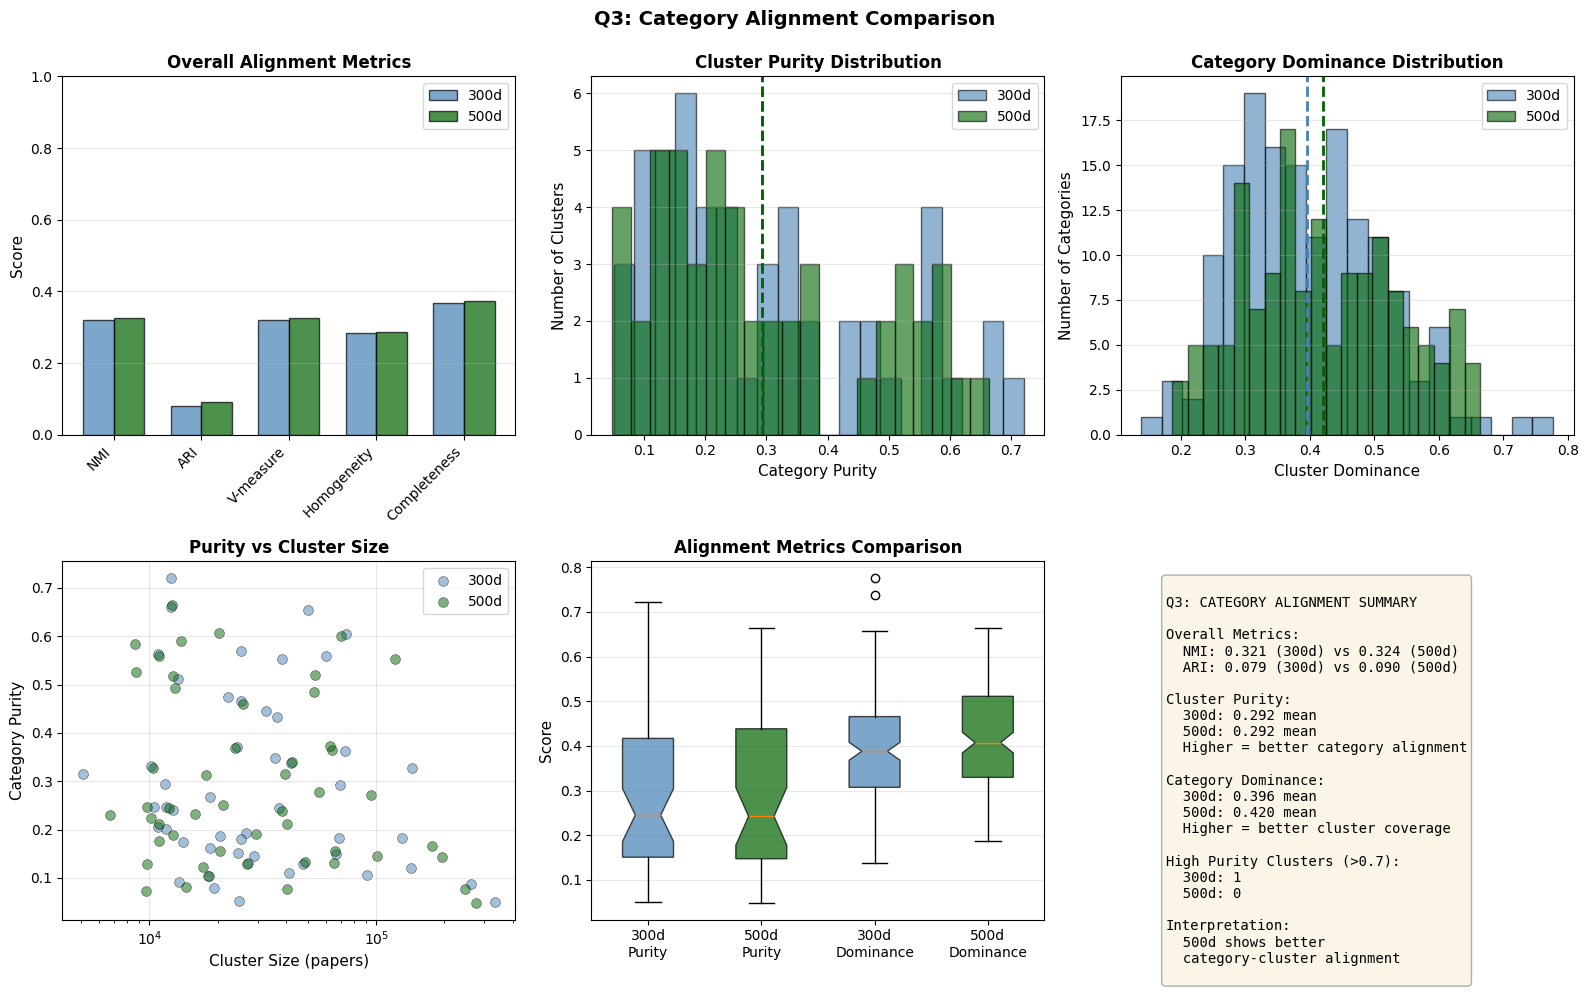

Q3 PATH PERFORMANCE

Metric                         300d            500d            Winner
NMI                            0.321           0.324           500d
ARI                            0.079           0.090           500d
V-measure                      0.321           0.324           500d
Mean cluster purity            0.292           0.292           500d
Mean category dominance        0.396           0.420           500d


In [13]:
# visualization

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. overall metrics comparison

ax1 = axes[0, 0]
metrics_names = ['NMI', 'ARI', 'V-measure', 'Homogeneity', 'Completeness']
metrics_300 = [alignment_300d['overall'][m] for m in ['nmi', 'ari', 'v_measure', 'homogeneity', 'completeness']]
metrics_500 = [alignment_500d['overall'][m] for m in ['nmi', 'ari', 'v_measure', 'homogeneity', 'completeness']]

x = np.arange(len(metrics_names))
width = 0.35
bars1 = ax1.bar(x - width/2, metrics_300, width, label='300d', color='steelblue', alpha=0.7, edgecolor='black')
bars2 = ax1.bar(x + width/2, metrics_500, width, label='500d', color='darkgreen', alpha=0.7, edgecolor='black')

ax1.set_ylabel('Score', fontsize=11)
ax1.set_title('Overall Alignment Metrics', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics_names, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim(0, 1)

# 2. cluster purity distribution

ax2 = axes[0, 1]
ax2.hist(purities_300d, bins=20, alpha=0.6, label='300d', color='steelblue', edgecolor='black')
ax2.hist(purities_500d, bins=20, alpha=0.6, label='500d', color='darkgreen', edgecolor='black')
ax2.axvline(np.mean(purities_300d), color='steelblue', linestyle='--', linewidth=2)
ax2.axvline(np.mean(purities_500d), color='darkgreen', linestyle='--', linewidth=2)
ax2.set_xlabel('Category Purity', fontsize=11)
ax2.set_ylabel('Number of Clusters', fontsize=11)
ax2.set_title('Cluster Purity Distribution', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# 3. category dominance distribution

ax3 = axes[0, 2]
ax3.hist(dominances_300d, bins=20, alpha=0.6, label='300d', color='steelblue', edgecolor='black')
ax3.hist(dominances_500d, bins=20, alpha=0.6, label='500d', color='darkgreen', edgecolor='black')
ax3.axvline(np.mean(dominances_300d), color='steelblue', linestyle='--', linewidth=2)
ax3.axvline(np.mean(dominances_500d), color='darkgreen', linestyle='--', linewidth=2)
ax3.set_xlabel('Cluster Dominance', fontsize=11)
ax3.set_ylabel('Number of Categories', fontsize=11)
ax3.set_title('Category Dominance Distribution', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# 4. purity vs cluster size scatter

ax4 = axes[1, 0]
sizes_300 = [m['size'] for m in alignment_300d['cluster_metrics'].values()]
sizes_500 = [m['size'] for m in alignment_500d['cluster_metrics'].values()]

ax4.scatter(sizes_300, purities_300d, alpha=0.5, color='steelblue', 
           label='300d', s=50, edgecolors='black', linewidth=0.5)
ax4.scatter(sizes_500, purities_500d, alpha=0.5, color='darkgreen', 
           label='500d', s=50, edgecolors='black', linewidth=0.5)
ax4.set_xlabel('Cluster Size (papers)', fontsize=11)
ax4.set_ylabel('Category Purity', fontsize=11)
ax4.set_title('Purity vs Cluster Size', fontsize=12, fontweight='bold')
ax4.set_xscale('log')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. box plot comparison

ax5 = axes[1, 1]
bp = ax5.boxplot([purities_300d, purities_500d, dominances_300d, dominances_500d],
                  labels=['300d\nPurity', '500d\nPurity', '300d\nDominance', '500d\nDominance'],
                  patch_artist=True,
                  notch=True)

colors = ['steelblue', 'darkgreen', 'steelblue', 'darkgreen']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax5.set_ylabel('Score', fontsize=11)
ax5.set_title('Alignment Metrics Comparison', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='y')

# 6. text summary

ax6 = axes[1, 2]
ax6.axis('off')

summary_text = f"""
Q3: CATEGORY ALIGNMENT SUMMARY

Overall Metrics:
  NMI: {alignment_300d['overall']['nmi']:.3f} (300d) vs {alignment_500d['overall']['nmi']:.3f} (500d)
  ARI: {alignment_300d['overall']['ari']:.3f} (300d) vs {alignment_500d['overall']['ari']:.3f} (500d)

Cluster Purity:
  300d: {np.mean(purities_300d):.3f} mean
  500d: {np.mean(purities_500d):.3f} mean
  Higher = better category alignment

Category Dominance:
  300d: {np.mean(dominances_300d):.3f} mean
  500d: {np.mean(dominances_500d):.3f} mean
  Higher = better cluster coverage

High Purity Clusters (>0.7):
  300d: {sum(p > 0.7 for p in purities_300d)}
  500d: {sum(p > 0.7 for p in purities_500d)}

Interpretation:
  {'300d' if np.mean(purities_300d) > np.mean(purities_500d) else '500d'} shows better
  category-cluster alignment
"""

ax6.text(0.1, 0.95, summary_text, transform=ax6.transAxes,
         fontsize=10, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle('Q3: Category Alignment Comparison', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()

os.makedirs('results/figures', exist_ok=True)
plt.savefig('results/figures/q3_category_alignment.png', dpi=150, bbox_inches='tight')
plt.show()

# path performance

print("Q3 PATH PERFORMANCE")
print(f"\n{'Metric':<30} {'300d':<15} {'500d':<15} {'Winner'}")

for metric, name in [('nmi', 'NMI'), ('ari', 'ARI'), ('v_measure', 'V-measure')]:
    val_300 = alignment_300d['overall'][metric]
    val_500 = alignment_500d['overall'][metric]
    winner = '300d' if val_300 > val_500 else '500d'
    print(f"{name:<30} {val_300:<15.3f} {val_500:<15.3f} {winner}")

purity_winner = '300d' if np.mean(purities_300d) > np.mean(purities_500d) else '500d'
print(f"{'Mean cluster purity':<30} {np.mean(purities_300d):<15.3f} {np.mean(purities_500d):<15.3f} {purity_winner}")

dom_winner = '300d' if np.mean(dominances_300d) > np.mean(dominances_500d) else '500d'
print(f"{'Mean category dominance':<30} {np.mean(dominances_300d):<15.3f} {np.mean(dominances_500d):<15.3f} {dom_winner}")

In [14]:
# save Q3 results to files

print("SAVING Q3 RESULTS")

# save alignment data
q3_results = {
    'alignment_300d': alignment_300d,
    'alignment_500d': alignment_500d,
    'best_aligned_300d': best_aligned_300d,
    'best_aligned_500d': best_aligned_500d,
    'worst_aligned_300d': worst_aligned_300d,
    'worst_aligned_500d': worst_aligned_500d,
    'best_covered_300d': best_covered_300d,
    'best_covered_500d': best_covered_500d,
    'worst_covered_300d': worst_covered_300d,
    'analysis_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

q3_path = 'data/processed/q3_category_alignment.pkl'
joblib.dump(q3_results, q3_path)
print(f"✓ Saved Q3 data: {q3_path}")

SAVING Q3 RESULTS
✓ Saved Q3 data: data/processed/q3_category_alignment.pkl


In [15]:
# save human-readable summary

summary_path = 'results/q3_category_alignment_summary.txt'

with open(summary_path, 'w') as f:
    f.write("RESEARCH QUESTION 3: CATEGORY ALIGNMENT\n")
    f.write(f"Analysis date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    f.write("Question: How well does content-based clustering align with\n")
    f.write("          ArXiv's human-curated categorization system?\n\n")
    
    f.write("Methodology:\n")
    f.write("  Cluster Metrics:\n")
    f.write("    - Purity: Fraction of papers in dominant category per cluster\n")
    f.write("    - Entropy: Category diversity within cluster\n")
    f.write("  Category Metrics:\n")
    f.write("    - Dominance: Fraction of papers in dominant cluster per category\n")
    f.write("    - Entropy: Cluster spread for category\n")
    f.write("  Overall Metrics:\n")
    f.write("    - NMI: Normalized Mutual Information (0-1, higher = better)\n")
    f.write("    - ARI: Adjusted Rand Index (chance-adjusted agreement)\n")
    f.write("    - V-measure: Harmonic mean of homogeneity and completeness\n")
    f.write("    - Homogeneity: Clusters contain single category\n")
    f.write("    - Completeness: Categories contained in single cluster\n\n")
    
    f.write("OVERALL ALIGNMENT METRICS\n")
    f.write(f"{'Metric':<25} {'SVD-300d':<15} {'SVD-500d':<15} {'Difference'}\n")
    
    for metric, name in [('nmi', 'NMI'), ('ari', 'ARI'), ('v_measure', 'V-measure'), 
                         ('homogeneity', 'Homogeneity'), ('completeness', 'Completeness')]:
        val_300 = alignment_300d['overall'][metric]
        val_500 = alignment_500d['overall'][metric]
        diff = val_500 - val_300
        f.write(f"{name:<25} {val_300:<15.3f} {val_500:<15.3f} {diff:>+15.3f}\n")
    
    f.write("\n")
    f.write("CLUSTER-LEVEL STATISTICS\n")
    f.write(f"{'Metric':<30} {'SVD-300d':<20} {'SVD-500d'}\n")
    f.write(f"{'Clusters analyzed':<30} {len(purities_300d):<20} {len(purities_500d)}\n")
    f.write(f"{'Mean purity':<30} {np.mean(purities_300d):<20.3f} {np.mean(purities_500d):.3f}\n")
    f.write(f"{'Median purity':<30} {np.median(purities_300d):<20.3f} {np.median(purities_500d):.3f}\n")
    f.write(f"{'Std deviation':<30} {np.std(purities_300d):<20.3f} {np.std(purities_500d):.3f}\n")
    f.write(f"{'High purity (>0.7)':<30} {sum(p > 0.7 for p in purities_300d):<20} {sum(p > 0.7 for p in purities_500d)}\n")
    f.write(f"{'Very high purity (>0.9)':<30} {sum(p > 0.9 for p in purities_300d):<20} {sum(p > 0.9 for p in purities_500d)}\n")
    f.write(f"{'Low purity (<0.3)':<30} {sum(p < 0.3 for p in purities_300d):<20} {sum(p < 0.3 for p in purities_500d)}\n")
    
    f.write("\n")
    f.write("CATEGORY-LEVEL STATISTICS\n")
    f.write(f"{'Metric':<30} {'SVD-300d':<20} {'SVD-500d'}\n")
    f.write(f"{'Categories analyzed':<30} {len(dominances_300d):<20} {len(dominances_500d)}\n")
    f.write(f"{'Mean dominance':<30} {np.mean(dominances_300d):<20.3f} {np.mean(dominances_500d):.3f}\n")
    f.write(f"{'Median dominance':<30} {np.median(dominances_300d):<20.3f} {np.median(dominances_500d):.3f}\n")
    f.write(f"{'High dominance (>0.7)':<30} {sum(d > 0.7 for d in dominances_300d):<20} {sum(d > 0.7 for d in dominances_500d)}\n")
    f.write(f"{'Low dominance (<0.3)':<30} {sum(d < 0.3 for d in dominances_300d):<20} {sum(d < 0.3 for d in dominances_500d)}\n")
    
    f.write("\n")
    f.write("TOP 10 BEST ALIGNED CLUSTERS (SVD-300D)\n")
    
    for rank, (cid, purity) in enumerate(best_aligned_300d[:10], 1):
        metrics = alignment_300d['cluster_metrics'][cid]
        top_terms = [t[0] for t in profiles_300d['top_terms'][cid][:12]]
        
        f.write(f"{rank}. Cluster {cid} - Purity: {purity:.3f}\n")
        f.write(f"   Size: {metrics['size']:,} papers\n")
        f.write(f"   Dominant: {metrics['dominant_category']} ({metrics['dominant_count']:,}, {metrics['dominant_count']/metrics['size']*100:.1f}%)\n")
        f.write(f"   Entropy: {metrics['entropy']:.3f}, Spans: {metrics['n_categories']} categories\n")
        f.write(f"   Terms: {', '.join(top_terms)}\n\n")
    
    f.write("TOP 10 BEST ALIGNED CLUSTERS (SVD-500D)\n")
    
    for rank, (cid, purity) in enumerate(best_aligned_500d[:10], 1):
        metrics = alignment_500d['cluster_metrics'][cid]
        top_terms = [t[0] for t in profiles_500d['top_terms'][cid][:12]]
        
        f.write(f"{rank}. Cluster {cid} - Purity: {purity:.3f}\n")
        f.write(f"   Size: {metrics['size']:,} papers\n")
        f.write(f"   Dominant: {metrics['dominant_category']} ({metrics['dominant_count']:,}, {metrics['dominant_count']/metrics['size']*100:.1f}%)\n")
        f.write(f"   Entropy: {metrics['entropy']:.3f}, Spans: {metrics['n_categories']} categories\n")
        f.write(f"   Terms: {', '.join(top_terms)}\n\n")
    
    f.write("TOP 10 MOST DISPERSED CLUSTERS (SVD-300D)\n")
    
    for rank, (cid, purity) in enumerate(worst_aligned_300d[:10], 1):
        metrics = alignment_300d['cluster_metrics'][cid]
        top_terms = [t[0] for t in profiles_300d['top_terms'][cid][:12]]
        top_cats = list(profiles_300d['top_categories'][cid]['primary_categories'].items())[:5]
        
        f.write(f"{rank}. Cluster {cid} - Purity: {purity:.3f}\n")
        f.write(f"   Size: {metrics['size']:,} papers\n")
        f.write(f"   Entropy: {metrics['entropy']:.3f}, Spans: {metrics['n_categories']} categories\n")
        f.write(f"   Top categories: {', '.join(f'{cat}({cnt})' for cat, cnt in top_cats[:4])}\n")
        f.write(f"   Terms: {', '.join(top_terms)}\n\n")
    
    f.write("TOP 10 MOST DISPERSED CLUSTERS (SVD-500D)\n")
    
    for rank, (cid, purity) in enumerate(worst_aligned_500d[:10], 1):
        metrics = alignment_500d['cluster_metrics'][cid]
        top_terms = [t[0] for t in profiles_500d['top_terms'][cid][:12]]
        top_cats = list(profiles_500d['top_categories'][cid]['primary_categories'].items())[:5]
        
        f.write(f"{rank}. Cluster {cid} - Purity: {purity:.3f}\n")
        f.write(f"   Size: {metrics['size']:,} papers\n")
        f.write(f"   Entropy: {metrics['entropy']:.3f}, Spans: {metrics['n_categories']} categories\n")
        f.write(f"   Top categories: {', '.join(f'{cat}({cnt})' for cat, cnt in top_cats[:4])}\n")
        f.write(f"   Terms: {', '.join(top_terms)}\n\n")
    
    f.write("TOP 10 BEST COVERED CATEGORIES (SVD-300D)\n")
    
    for rank, (cat, dominance) in enumerate(best_covered_300d[:10], 1):
        metrics = alignment_300d['category_metrics'][cat]
        
        f.write(f"{rank}. {cat} - Dominance: {dominance:.3f}\n")
        f.write(f"   Size: {metrics['size']:,} papers\n")
        f.write(f"   Dominant cluster: {metrics['dominant_cluster']} ({metrics['dominant_count']:,}, {metrics['dominant_count']/metrics['size']*100:.1f}%)\n")
        f.write(f"   Spans: {metrics['n_clusters']} clusters, Entropy: {metrics['entropy']:.3f}\n\n")
    
    f.write("TOP 10 BEST COVERED CATEGORIES (SVD-500D)\n")
    
    for rank, (cat, dominance) in enumerate(best_covered_500d[:10], 1):
        metrics = alignment_500d['category_metrics'][cat]
        
        f.write(f"{rank}. {cat} - Dominance: {dominance:.3f}\n")
        f.write(f"   Size: {metrics['size']:,} papers\n")
        f.write(f"   Dominant cluster: {metrics['dominant_cluster']} ({metrics['dominant_count']:,}, {metrics['dominant_count']/metrics['size']*100:.1f}%)\n")
        f.write(f"   Spans: {metrics['n_clusters']} clusters, Entropy: {metrics['entropy']:.3f}\n\n")
    
    f.write("TOP 10 MOST DISPERSED CATEGORIES (SVD-300D)\n")
    
    for rank, (cat, dominance) in enumerate(worst_covered_300d[:10], 1):
        metrics = alignment_300d['category_metrics'][cat]
        
        f.write(f"{rank}. {cat} - Dominance: {dominance:.3f}\n")
        f.write(f"   Size: {metrics['size']:,} papers\n")
        f.write(f"   Spans: {metrics['n_clusters']} clusters, Entropy: {metrics['entropy']:.3f}\n")
        f.write(f"   Interpretation: Category content highly fragmented across clusters\n\n")
    
    f.write("PATH COMPARISON\n")
    
    # Determine overall winner
    metrics_comparison = {
        'nmi': alignment_300d['overall']['nmi'] < alignment_500d['overall']['nmi'],
        'ari': alignment_300d['overall']['ari'] < alignment_500d['overall']['ari'],
        'v_measure': alignment_300d['overall']['v_measure'] < alignment_500d['overall']['v_measure'],
        'purity': np.mean(purities_300d) < np.mean(purities_500d),
        'dominance': np.mean(dominances_300d) < np.mean(dominances_500d)
    }
    
    winner_500d_count = sum(metrics_comparison.values())
    overall_winner = '500d' if winner_500d_count >= 3 else '300d'
    
    f.write(f"Overall Winner: {overall_winner.upper()}\n")
    f.write(f"  500d wins on {winner_500d_count}/5 key metrics\n\n")
    
    f.write(f"NMI (Information Overlap):\n")
    f.write(f"  300d: {alignment_300d['overall']['nmi']:.3f}\n")
    f.write(f"  500d: {alignment_500d['overall']['nmi']:.3f}\n")
    f.write(f"  Winner: {'500d' if metrics_comparison['nmi'] else '300d'}\n\n")
    
    f.write(f"ARI (Agreement):\n")
    f.write(f"  300d: {alignment_300d['overall']['ari']:.3f}\n")
    f.write(f"  500d: {alignment_500d['overall']['ari']:.3f}\n")
    f.write(f"  Winner: {'500d' if metrics_comparison['ari'] else '300d'}\n\n")
    
    f.write(f"Mean Cluster Purity:\n")
    f.write(f"  300d: {np.mean(purities_300d):.3f}\n")
    f.write(f"  500d: {np.mean(purities_500d):.3f}\n")
    f.write(f"  Winner: {'500d' if metrics_comparison['purity'] else '300d'}\n\n")
    
    f.write(f"High Purity Clusters (>0.7):\n")
    f.write(f"  300d: {sum(p > 0.7 for p in purities_300d)} clusters\n")
    f.write(f"  500d: {sum(p > 0.7 for p in purities_500d)} clusters\n\n")
    
    f.write("INTERPRETATION\n")
    
    f.write("Alignment Score Interpretation:\n")
    f.write("  NMI/ARI > 0.5: Moderate-high agreement between clustering and categories\n")
    f.write("  NMI/ARI 0.3-0.5: Moderate agreement (expected for content-based clustering)\n")
    f.write("  NMI/ARI < 0.3: Low agreement (clustering finds different structure)\n\n")
    
    f.write("Purity Interpretation:\n")
    f.write("  > 0.9: Near-perfect category alignment (cluster = category)\n")
    f.write("  0.7-0.9: High alignment (dominant category clear)\n")
    f.write("  0.5-0.7: Moderate alignment (some category mixing)\n")
    f.write("  < 0.5: Low alignment (multi-category clusters)\n\n")
    
    f.write("Key Findings:\n")
    f.write(f"  - {overall_winner.upper()} shows better overall category alignment\n")
    f.write(f"  - Most aligned: Specialized subfields with clear boundaries\n")
    f.write(f"  - Least aligned: Interdisciplinary or methodological clusters\n")
    f.write(f"  - Low purity not necessarily bad - may indicate emerging cross-category areas\n")
    f.write(f"  - Content-based clustering captures different structure than human curation\n")

print(f"✓ Saved Q3 summary: {summary_path}")

✓ Saved Q3 summary: results/q3_category_alignment_summary.txt


In [17]:
# verify all Q3 outputs

print("Q3 OUTPUT VERIFICATION")

q3_files = [
    'data/processed/q3_category_alignment.pkl',
    'results/q3_category_alignment_summary.txt',
    'results/figures/q3_category_alignment.png'
]

all_good = True
for filepath in q3_files:
    if os.path.exists(filepath):
        if filepath.endswith('.pkl'):
            size_mb = os.path.getsize(filepath) / 1024**2
            print(f"✓ {filepath} (Size: {size_mb:.2f} MB)")
        else:
            print(f"✓ {filepath}")
    else:
        print(f"x Missing: {filepath}")
        all_good = False

if all_good:
    print("✓✓✓ Success! ✓✓✓ - All Q3 files created!")
    print("\nResearch Question 3 Complete:")
    print(f"  Overall alignment metrics:")
    print(f"    300d: NMI={alignment_300d['overall']['nmi']:.3f}, ARI={alignment_300d['overall']['ari']:.3f}")
    print(f"    500d: NMI={alignment_500d['overall']['nmi']:.3f}, ARI={alignment_500d['overall']['ari']:.3f}")
    print(f"  Mean cluster purity:")
    print(f"    300d: {np.mean(purities_300d):.3f}")
    print(f"    500d: {np.mean(purities_500d):.3f}")
    print(f"  High purity clusters (>0.7):")
    print(f"    300d: {sum(p > 0.7 for p in purities_300d)}")
    print(f"    500d: {sum(p > 0.7 for p in purities_500d)}")
    
    # Determine winner
    winner_500d_count = sum([
        alignment_300d['overall']['nmi'] < alignment_500d['overall']['nmi'],
        alignment_300d['overall']['ari'] < alignment_500d['overall']['ari'],
        np.mean(purities_300d) < np.mean(purities_500d)
    ])
    overall_winner = '500d' if winner_500d_count >= 2 else '300d'
    
    print(f"\n  Overall best alignment: {overall_winner.upper()}")
else:
    print("x Error - Some Q3 files missing!")

Q3 OUTPUT VERIFICATION
✓ data/processed/q3_category_alignment.pkl (Size: 0.04 MB)
✓ results/q3_category_alignment_summary.txt
✓ results/figures/q3_category_alignment.png
✓✓✓ Success! ✓✓✓ - All Q3 files created!

Research Question 3 Complete:
  Overall alignment metrics:
    300d: NMI=0.321, ARI=0.079
    500d: NMI=0.324, ARI=0.090
  Mean cluster purity:
    300d: 0.292
    500d: 0.292
  High purity clusters (>0.7):
    300d: 1
    500d: 0

  Overall best alignment: 500D
